In [1]:
import re
import string

import numpy as np
import pandas as pd
from pathlib import Path
from unidecode import unidecode
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import seaborn as sns
#import umap
#from umap import UMAP
import umap.umap_ as umap
import umap.plot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

/home/gabriel/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv(Path('DadosPortarias'))

In [3]:
df.drop('dataEfetiva',axis=1,inplace=True)
df.drop('interessado',axis=1,inplace=True)
df.drop('matricula',axis=1,inplace=True)

In [4]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5410 entries, 0 to 5409
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        5410 non-null   int64 
 1   textoConsolidado  5410 non-null   object
 2   assunt            5397 non-null   object
dtypes: int64(1), object(2)
memory usage: 126.9+ KB


,Unnamed: 0,textoConsolidado,assunt
0,0,MINISTÉRIO DA EDUCAÇÃO Secretaria de Educação ...,GENÉRICA FISCAL DE CONTRATO
1,1,MINISTÉRIO DA EDUCAÇÃO Secretaria de Educação ...,GENÉRICA FISCAL DE CONTRATO
2,2,MINISTÉRIO DA EDUCAÇÃO Secretaria de Educação ...,GENÉRICA FISCAL DE CONTRATO
3,3,MINISTÉRIO DA EDUCAÇÃO Secretaria de Educação ...,GENÉRICA FISCAL DE CONTRATO
4,4,MINISTÉRIO DA EDUCAÇÃO Secretaria de Educação ...,GENÉRICA FISCAL DE CONTRATO


In [5]:
df["texto"] = df["textoConsolidado"] + df["assunt"]
df.drop('textoConsolidado', axis=1, inplace=True)
df.drop('assunt', axis=1, inplace=True)

In [6]:
df[df["texto"].isna()]

,Unnamed: 0,texto
951,951,NaN
952,952,NaN
953,953,NaN
1583,1583,NaN
1584,1584,NaN
1585,1585,NaN
1586,1586,NaN
1587,1587,NaN
1588,1588,NaN
1589,1589,NaN


In [7]:
df.dropna(subset=['texto'],inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5397 entries, 0 to 5409
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5397 non-null   int64 
 1   texto       5397 non-null   object
dtypes: int64(1), object(1)
memory usage: 126.5+ KB


In [9]:
df["texto"] = df['texto'].str.lower()

In [10]:
# Remoção de pontuação e símbolos

# Tabela de pontuação
punctuation = string.punctuation
# Criar tabela de tradução que susbstituirá toda ponutação por um espaço em branco
trantab = str.maketrans(punctuation, len(punctuation)*' ')
# Traduzir nosso exemplo
df["texto"] = df['texto'].str.translate(trantab)

df.head()

,Unnamed: 0,texto
0,0,ministério da educação secretaria de educação ...
1,1,ministério da educação secretaria de educação ...
2,2,ministério da educação secretaria de educação ...
3,3,ministério da educação secretaria de educação ...
4,4,ministério da educação secretaria de educação ...


In [11]:
df['texto']=[unidecode(x) for x in df['texto']]

In [12]:
df['texto'][0] #Visualizar primeiras modificações

'ministerio da educacao secretaria de educacao profissional e tecnologica instituto federal de educacao  ciencia e tecnologia de goias reitoria portaria no 2244   reitoria ifg  de 30 de agosto de 2022 a reitora do instituto federal de educacao  ciencia e tecnologia de goias  ifg    nomeada por decreto presidencial de 5 de outubro de 2021  publicado no diario oficial da uniao de 6 10 2021  no uso de suas atribuicoes legais e regimentais  considerando o que consta no processo no 23372 002069 2022 69   resolve  art  1o designar como fiscais os servidores  conforme se segue  de acordo com o previsto no art  67 da lei no 8 666  de 21 de junho de 1993  e legislacao correlata  na instrucao normativa seges mpdg no 5  de 25 de maio de 2017  para gerenciarem  acompanharem e fiscalizarem a execucao e o adequado cumprimento das clausulas estabelecidas no contrato no 16 2022  celebrado entre o a  reitoria e a empresa msm engenharia ltda   cnpj  37 320 553 0001 31  cujo objeto e a realizacao de obra

In [13]:
# Remover dígitos

def remove_digits(input_text):
    import re
    return re.sub('\d+', '', input_text)

df['texto']=[remove_digits(x) for x in df['texto']]
df['texto'][0]

'ministerio da educacao secretaria de educacao profissional e tecnologica instituto federal de educacao  ciencia e tecnologia de goias reitoria portaria no    reitoria ifg  de  de agosto de  a reitora do instituto federal de educacao  ciencia e tecnologia de goias  ifg    nomeada por decreto presidencial de  de outubro de   publicado no diario oficial da uniao de     no uso de suas atribuicoes legais e regimentais  considerando o que consta no processo no       resolve  art  o designar como fiscais os servidores  conforme se segue  de acordo com o previsto no art   da lei no    de  de junho de   e legislacao correlata  na instrucao normativa seges mpdg no   de  de maio de   para gerenciarem  acompanharem e fiscalizarem a execucao e o adequado cumprimento das clausulas estabelecidas no contrato no    celebrado entre o a  reitoria e a empresa msm engenharia ltda   cnpj        cujo objeto e a realizacao de obras de execucao dos projetos de prevencao e combate a incendio e panico   ppcip d

In [14]:
# Remover stopwords

try:
    stopwords_list = stopwords.words('portuguese')
except:
    nltk.download('stopwords')
    stopwords_list = stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabriel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
newStopWords=['diario','publicado','presidencial','decreto','reitora','educacaosecretaria','ministerio','educacao','secretaria', 'profissional','tecnologica', 'tecnologicainstituto', 'federal', 'ciencia', 'tecnologia', 'goiasreitoriaportaria', 'goias', 'reitoria', 'portaria', 'ifg', 'instituto', 'oficial', 'uniao', 'atribuicoes', 'legais', 'regimentais'] 
stopwords_list.extend(newStopWords)

In [16]:
def remove_stopwords(input_text, stopwords_list):
    words = input_text.split()
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 1]
    return " ".join(clean_words)

df['texto'] = [remove_stopwords(x, stopwords_list) for x in df['texto']] 
df['texto'][0]

'agosto nomeada outubro uso considerando consta processo resolve art designar fiscais servidores conforme segue acordo previsto art lei junho legislacao correlata instrucao normativa seges mpdg maio gerenciarem acompanharem fiscalizarem execucao adequado cumprimento clausulas estabelecidas contrato celebrado empresa msm engenharia ltda cnpj cujo objeto realizacao obras execucao projetos prevencao combate incendio panico ppcip campus aparecida goiania formosa jatai luziania valparaiso conforme detalhamento seguir item referente campus aparecida goiania titular funcao matricula siape raissa regis silva gestor erique souza zanon fiscal tecnico titular cesar oliveira guimaraes fiscal tecnico substituto rodrigo souza arantes fiscal administrativo item referente campus formosa titular funcao matricula siape ricardo noronha tristao gestor erique souza zanon fiscal tecnico titular cesar oliveira guimaraes fiscal tecnico substituto milton pereira neves filho fiscal administrativo item referente

In [17]:
# O TF-IDF

# Instanciar o vetorizador do sklearn
tfv = TfidfVectorizer(binary=True) #Fazer em binário
# Ajustar os pesos e fazer a transformação do corpus para a representação TF-IDF
tfidf = tfv.fit_transform(df['texto'])

tfidf = pd.DataFrame.sparse.from_spmatrix(tfidf, columns=tfv.get_feature_names())
tfidf.shape

/home/gabriel/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(5397, 3974)

In [18]:
#Defindo o rótulo de cada portaria
categoria = pd.read_csv(Path('Categorias2.csv'))

In [19]:
categoria.head()

,categoria,texto
0,A,Conselho de Ensino Pesquisa e Extensão 1 Gen...
1,A,Conselho Superior 1 Genérica Atualização CONSUP
2,A,Conselho de Câmpus 1 Genérica Conselho de Câm...
3,A,Conselho de Câmpus 2 Genérica Atualização Con...
4,A,Conselho de Câmpus 3 Genérica Secretaria do C...


In [20]:
#Alguns pré-processamentos para as categorias
categoria["texto"] = categoria['texto'].str.lower()
# Remoção de pontuação e símbolos
# Traduzir nosso exemplo
categoria["texto"] = categoria['texto'].str.translate(trantab)

categoria['texto']=[unidecode(x) for x in categoria['texto']]
categoria['texto']=[remove_digits(x) for x in categoria['texto']]

categoria['texto'] = [remove_stopwords(x, stopwords_list) for x in categoria['texto']] 

In [21]:
set1=tfv.get_feature_names()

/home/gabriel/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [22]:
tfv.get_feature_names()

['abadia',
 'abadio',
 'abastecimento',
 'abc',
 'abdala',
 'abdalla',
 'abec',
 'aberta',
 'abilio',
 'abimael',
 'abishai',
 'abnner',
 'abono',
 'abrantes',
 'abrao',
 'abreu',
 'abril',
 'academica',
 'academicas',
 'academico',
 'academicos',
 'acao',
 'aceleracao',
 'acessibilidade',
 'acesso',
 'acessorios',
 'aciole',
 'acoes',
 'acompanhamento',
 'acompanhando',
 'acompanhar',
 'acompanharem',
 'acordo',
 'acordos',
 'adad',
 'adalberto',
 'adao',
 'adapatacoes',
 'adaptacao',
 'adaptacoes',
 'adauto',
 'adel',
 'ademar',
 'adequacao',
 'adequacoes',
 'adequado',
 'aderito',
 'adicionais',
 'adicional',
 'adilson',
 'adjudicadas',
 'adjunta',
 'adjunto',
 'adm',
 'administraao',
 'administracao',
 'administrador',
 'administradora',
 'administrar',
 'administrativa',
 'administrativas',
 'administrativo',
 'administrativos',
 'admitida',
 'admprf',
 'adolfo',
 'adorno',
 'adotante',
 'adria',
 'adriam',
 'adriana',
 'adriane',
 'adriano',
 'adrielly',
 'adultos',
 'aelton',
 '

In [23]:
len(set1)

3974

In [24]:
#Análise de intersecção
#Pegar dicionario
tfv2 = TfidfVectorizer(binary=True)
# Ajustar os pesos e fazer a transformação do corpus para a representação TF-IDF
temp2 = tfv2.fit_transform(categoria['texto'])

In [25]:
set2=tfv2.get_feature_names()
len(set2)

196

In [26]:
len(set(set2).difference(set(set1)))

20

In [27]:
len(set2)

196

In [28]:
rotulo = tfv.transform(categoria['texto']) # temos 2 tabelas com mesma quantidade de colunas
rotulo = pd.DataFrame.sparse.from_spmatrix(rotulo, columns=tfv.get_feature_names())

In [29]:
tfidf.shape #mesma quantidade de linhas que os rotulos

(5397, 3974)

In [30]:
rotulo.shape

(80, 3974)

In [31]:
rotulo.values[1]

array([0., 0., 0., ..., 0., 0., 0.])

In [32]:
len(tfidf)
tfidf.shape

(5397, 3974)

In [33]:
multiplicação = cosine_similarity(tfidf,rotulo)

In [34]:
multiplicação[0].max()

0.22812914737632928

In [35]:
np.argmax(multiplicação[0])

75

In [36]:
categoria.iloc[0]['categoria']

'A'

In [37]:
for index, item in enumerate(multiplicação):
    tfidf.at[index, 'rotulo'] = categoria.iloc[np.argmax(item)]['categoria']
    

In [38]:
tfidf['rotulo'][0]

'G'

In [39]:
categoria.at[75, 'categoria']

'G'

In [40]:
#1Gerar TF-IDF das portarias de forma binária
#2Aplicar o transform para os dados de categorias
#3Rotular as portarias multiplicando portaria por categorias e atribuindo o rótulo com maior valor de multiplicação. 
#Importante, categorias com vetorezes zerados já recebem categoria N

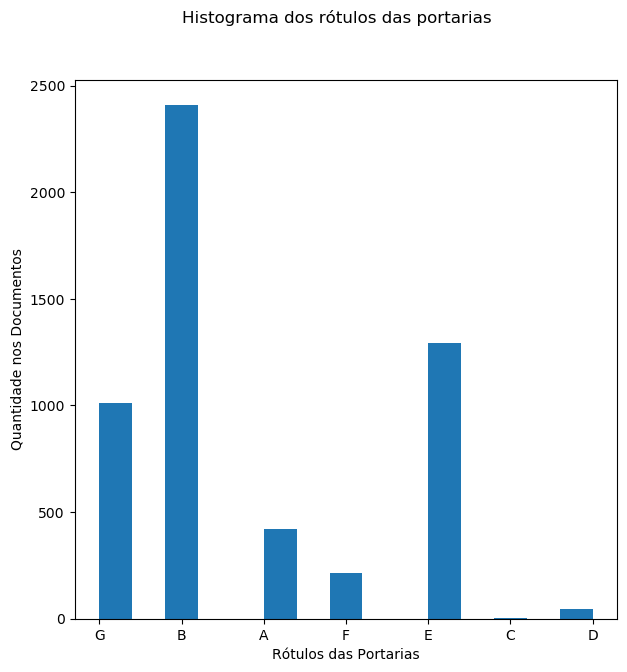

In [41]:
#Crie um histograma mostrando a variação no tamanho de cada portaria. 
#https://github.com/hundredblocks/ml-powered-applications/blob/master/notebooks/dataset_exploration.ipynb
fig = plt.figure(figsize=(7,7))
fig.suptitle("Histograma dos rótulos das portarias")
plt.xlabel("Rótulos das Portarias")
plt.ylabel("Quantidade nos Documentos")
q_len = plt.hist(tfidf['rotulo'],  bins=15,log=False, align='mid')

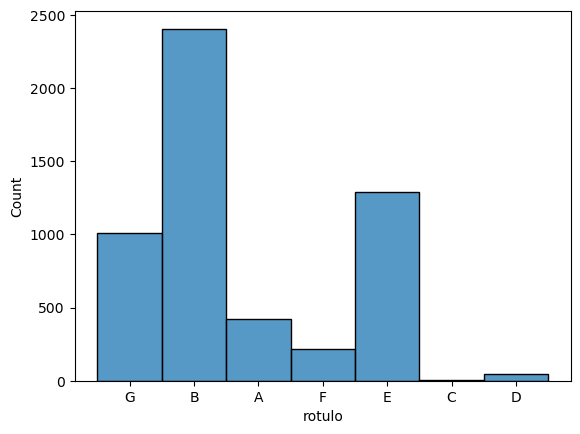

In [42]:
#Mostrar um histograma por categoria para análise de balanceamento
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
sns.histplot(tfidf['rotulo'])

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


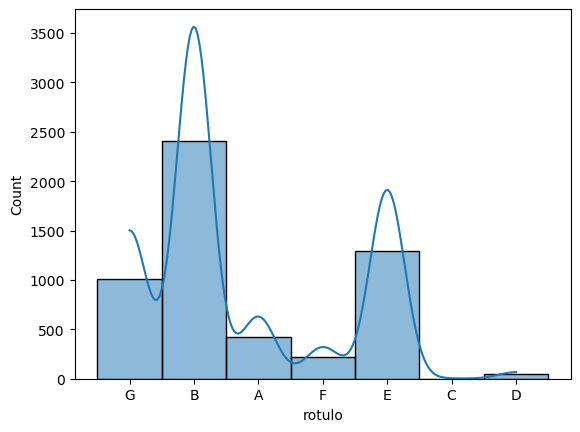

In [43]:
sns.histplot(tfidf['rotulo'], kde=True)

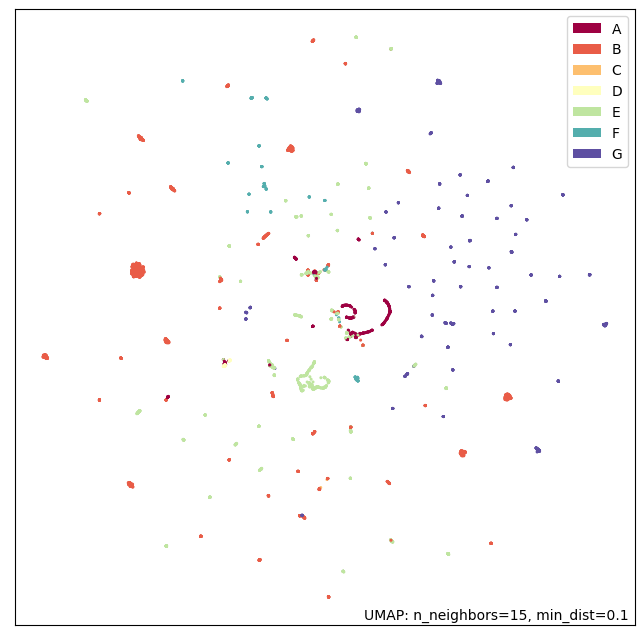

In [44]:
#Motrar Gráfico UMPA: Dados por Categoria usando rótulos
#https://github.com/hundredblocks/ml-powered-applications/blob/master/notebooks/vectorizing_text.ipynb

#Utilizando um método diferente do mostrado nesse link acima.
mapper = umap.UMAP().fit(multiplicação)
sent_labels = tfidf['rotulo']
sent_labels.value_counts()
umap.plot.points(mapper, labels=sent_labels)

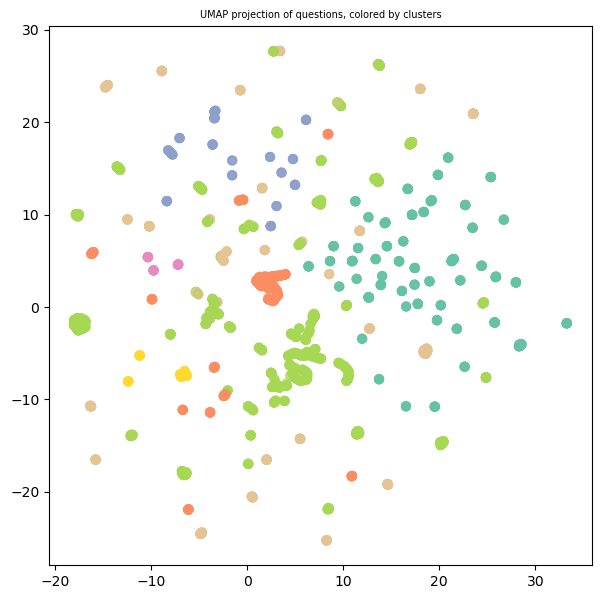

In [75]:
#Mostrar Gráfico Clustering: Dados em clusters NClusters = #Categorias
#https://github.com/hundredblocks/ml-powered-applications/blob/master/notebooks/clustering_data.ipynb

umap_embedder = umap.UMAP()
umap_features = umap_embedder.fit_transform(multiplicação)

# Choose number of clusters and colormap
n_clusters=7
cmap = plt.get_cmap("Set2")
fig = plt.figure(figsize=(7, 7))


# Fit clustering algorithm to our vectorized features
clus = KMeans(n_clusters=n_clusters, random_state=10)
clusters = clus.fit_predict(multiplicação)

# Plot the dimentionality reduced features on a 2D plane
plt.scatter(umap_features[:, 0], umap_features[:, 1], 
            c=[cmap(x/n_clusters) for x in clusters], s=40, alpha=.4)
plt.title('UMAP projection of questions, colored by clusters', fontsize=7);

### Regressão linear

In [46]:
rotulos_mapper = {"A":0, "B":1, "C":2, "D":3, "E":4, "F":5, "G":6}
tfidf['rotulo'] = tfidf['rotulo'].replace(rotulos_mapper)
tfidf['rotulo']

0       6
1       6
2       6
3       6
4       6
       ..
5392    4
5393    4
5394    4
5395    4
5396    1
Name: rotulo, Length: 5397, dtype: int64

In [47]:
train_set, test_set = train_test_split(tfidf, test_size=0.2, random_state=42)
print(len(train_set), "train +", len(test_set), "test")

4317 train + 1080 test


In [48]:
y_train, y_test = train_set['rotulo'], test_set['rotulo']

In [49]:
x_train, x_test = train_set.drop(['rotulo'], axis=1), test_set.drop(['rotulo'], axis=1)
x_train.head()

,abadia,abadio,abastecimento,abc,abdala,abdalla,abec,aberta,abilio,abimael,...,zelar,zenon,zepim,zildaelei,zilka,zilma,zimmer,zona,zorzi,zuppa
4148,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0669,0.0,0.0,0.07287
2809,0.039710,0.0,0.0,0.0,0.045996,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.00000
621,0.033998,0.0,0.0,0.0,0.000000,0.032542,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.00000
566,0.033998,0.0,0.0,0.0,0.000000,0.032542,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.00000
1957,0.000000,0.0,0.0,0.0,0.000000,0.057114,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.00000


In [50]:
lin_reg = LinearRegression()
lin_reg.fit(x_train,y_train)
resultado=lin_reg.predict(x_test)

In [51]:
resultado

array([0.9999443 , 6.00001391, 3.29998722, ..., 0.99999997, 0.99999586,
       9.05916299])

In [52]:
#arredondando para inteiros
resultado = [round(x) for x in resultado]

In [53]:
resultado

[1,
 6,
 3,
 6,
 1,
 4,
 5,
 6,
 4,
 4,
 4,
 4,
 6,
 1,
 1,
 1,
 1,
 3,
 1,
 6,
 1,
 1,
 1,
 1,
 6,
 1,
 1,
 7,
 1,
 2,
 7,
 1,
 0,
 1,
 4,
 -1,
 3,
 4,
 6,
 6,
 9,
 7,
 1,
 4,
 6,
 1,
 4,
 -8,
 1,
 4,
 6,
 6,
 1,
 4,
 1,
 8,
 1,
 3,
 6,
 1,
 6,
 2,
 2,
 1,
 1,
 -2,
 3,
 1,
 1,
 4,
 6,
 1,
 6,
 1,
 1,
 1,
 1,
 4,
 6,
 6,
 4,
 4,
 6,
 6,
 -2,
 4,
 7,
 1,
 4,
 1,
 9,
 1,
 8,
 6,
 6,
 6,
 1,
 6,
 6,
 1,
 4,
 1,
 -6,
 4,
 1,
 1,
 6,
 8,
 0,
 1,
 1,
 -1,
 1,
 6,
 6,
 1,
 1,
 4,
 6,
 6,
 1,
 1,
 5,
 5,
 6,
 1,
 3,
 1,
 6,
 7,
 6,
 7,
 6,
 -2,
 4,
 6,
 1,
 3,
 6,
 5,
 6,
 6,
 1,
 1,
 4,
 1,
 1,
 2,
 6,
 1,
 1,
 6,
 1,
 1,
 14,
 4,
 2,
 1,
 1,
 1,
 1,
 6,
 1,
 4,
 -4,
 0,
 4,
 6,
 1,
 5,
 1,
 6,
 1,
 1,
 6,
 1,
 1,
 0,
 1,
 1,
 6,
 1,
 1,
 1,
 1,
 1,
 6,
 6,
 1,
 -3,
 2,
 6,
 3,
 4,
 1,
 4,
 1,
 4,
 4,
 4,
 6,
 5,
 4,
 -2,
 -10,
 1,
 6,
 6,
 1,
 1,
 4,
 2,
 1,
 1,
 1,
 6,
 4,
 1,
 1,
 6,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 4,
 6,
 2,
 2,
 4,
 7,
 4,
 6,
 1,
 4,
 1,
 1,
 1,
 6,
 1,
 -3,
 0,
 1,
 4

In [54]:
#o melhor valor é 0.0
print(mean_squared_error(y_test, resultado))

2.573148148148148


In [55]:
#o melhor valor é 0.0
print(mean_absolute_error(y_test, resultado))

0.5805555555555556


In [56]:
#o melhor valor é 1.0
print(r2_score(y_test, resultado))

0.45501690520375215


In [57]:
lin_reg.coef_

array([18.90090909, -0.98646565,  0.59135348, ...,  0.51861891,
        0.26999377, -4.02643781])

In [58]:
np.argmax(lin_reg.coef_)

277

In [59]:
#feature de maior relevância
tfidf.columns[277]

'arantes'